In [1]:
#import econtools
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
#pd.set_option('max_columns',200) # Den er smart fordi så kan du se alle kolonnenavne når du fx laver cars.head()
#pd.set_option('max_rows',200) 
pd.set_option('display.float_format', '{:.3f}'.format) # Set decimals 


# Plot choices
sns.set(style="whitegrid")

# Import data and add columns
Also changes dtypes from data set

In [2]:
# Import data
cars = pd.read_csv('cars.csv')

# Data cleaning - replacing commas and converting to float
columns_to_clean = ['hp', 'li', 'li1', 'li2', 'li3', 'ngdp', 'rgdp', 'princ', 'pr', 'tax', 'avdexr']
for column in columns_to_clean:
    if column in cars.columns:
        cars[column] = cars[column].str.replace(',', '.').astype(float)


labs = pd.read_csv('labels_values.csv')
dict_varnames = pd.read_csv('labels_variables.csv').set_index('variable').to_dict()['label']

# to translate market indices to names of countries 
labs.index += 1 
dict_ma = labs.market.dropna().to_dict()


cars['country'] = cars['ma'].map(dict_ma)

dict_cla = labs.classs.dropna().to_dict()
cars['class'] = cars['cla'].map(dict_cla)

## Add annual fuel price column
$\text{Yearly cost} = \frac{\text{Price per Barrel Oil}}{158 Liters\times 0.43} \times \frac{\text{li}}{100} \times \text{Yearly Driving Distance}$

The price is in dollar (so data for the yearly exchange rate will firstly be imported)


**Generel formel for årlig omkostning af olie**

Exchange rate: **Måske/Måske ikke bruges**

**Fuel price:**

In [3]:
# 'avg_km': how many km is avg in each market (skal have data for hvert land)
market_annual_driving = {
    1: 11300,
    2: 11300,
    3: 11300,
    4: 11300,
    5: 11300
}

# Map annual kilometers to cars data
cars['ann_km'] = cars['ma'].map(market_annual_driving)

# Load oil prices and calculate fuel price per liter
oil = pd.read_csv('oilPriceDollars.csv')
oil['ye'] = oil['Year'].astype(str).str[-2:].astype(int)

#Måske ændre dette
fuel_from_oil = 158 * 0.43  # L from barrel * energy content factor

# Fuel price for 1L 
oil['Fuel_price_1L'] = (oil['priceDollars'] / fuel_from_oil)

# Merge cars data with oil prices
cars = cars.merge(oil, on='ye', how='left')

# Calculate annual fuel cost in dollars
cars['Fuel_price_ann_dollar'] = cars['Fuel_price_1L'] * cars['ann_km'] * (cars['li'] / 100)

# Adjust car prices using 'princ'
cars['pr_dollar'] = cars['pr'] / cars['princ']

# Adjust car prices by GDP per capita
cars['pr_dollar_inc'] = cars['pr_dollar'] / ((cars['ngdp'] / cars['princ']) / cars['pop'])

# Output the modified DataFrame
cars

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,ergdpc,country,class,ann_km,Year,priceDollars,Fuel_price_1L,Fuel_price_ann_dollar,pr_dollar,pr_dollar_inc
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,"9998,876953",Belgium,compact,11300,1983,26.190,0.385,338.316,424827.606,0.791
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,"9522,693359",Belgium,compact,11300,1984,25.880,0.381,334.312,457667.306,0.762
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,"9715,203125",Belgium,compact,11300,1985,24.090,0.355,311.189,490304.253,0.736
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,"11212,44141",Belgium,compact,11300,1986,12.510,0.184,161.601,515709.951,0.659
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,"12348,46387",Belgium,compact,11300,1987,15.400,0.227,203.203,538875.387,0.649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,NaN,UK,luxury,11300,1999,15.560,0.229,222.567,15289.863,1.500
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,NaN,UK,standard,11300,1999,15.560,0.229,238.958,15289.864,1.196
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,NaN,UK,subcompact,11300,1999,15.560,0.229,181.159,15289.863,0.490
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,NaN,UK,subcompact,11300,1999,15.560,0.229,172.533,15289.863,0.513


Link to oilprices pr. year: https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=F000000__3&f=A

## Add average carbon emissions - CO2 udledning


In [4]:
#This is how many liters a car is using each year when driving 11300km 
cars['li_qu'] = (cars['li']/100)*cars['ann_km']
cars['li_qu_total'] = (cars['li']/100)*cars['ann_km']*cars['qu']


# This is the annual liters used times the emission factor = the total co2 emission every year
emission_factor = 2.39
cars['avg_ann_co2']= cars['li_qu'] * emission_factor
cars['avg_ann_co2_total']= cars['li_qu_total'] * emission_factor

cars

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,Year,priceDollars,Fuel_price_1L,Fuel_price_ann_dollar,pr_dollar,pr_dollar_inc,li_qu,li_qu_total,avg_ann_co2,avg_ann_co2_total
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1983,26.190,0.385,338.316,424827.606,0.791,877.633,639794.718,2097.544,1529109.377
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1984,25.880,0.381,334.312,457667.306,0.762,877.633,1632398.047,2097.544,3901431.332
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1985,24.090,0.355,311.189,490304.253,0.736,877.633,1554288.678,2097.544,3714749.940
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1986,12.510,0.184,161.601,515709.951,0.659,877.633,1796515.485,2097.544,4293672.009
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1987,15.400,0.227,203.203,538875.387,0.649,896.467,1924713.949,2142.555,4600066.338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,1999,15.560,0.229,222.567,15289.863,1.500,971.800,3655911.762,2322.602,8737629.111
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,1999,15.560,0.229,238.958,15289.864,1.196,1043.367,8384494.765,2493.646,20038942.487
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,1999,15.560,0.229,181.159,15289.863,0.490,791.000,13541129.000,1890.490,32363298.310
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,1999,15.560,0.229,172.533,15289.863,0.513,753.333,3496973.250,1800.467,8357766.068


**Total sale for all markets and years (1 number)**

In [5]:
# Sum market share 
cars['qu_total'] = cars['qu'].sum()


**Total sale for each year (30 numbers) => 30 years**

In [6]:
cars['qu_total_ye'] = cars.groupby(['ye'])['qu'].transform('sum')

**Total sale for each market (5 numbers) => 5 countries**

In [7]:
cars['qu_total_ma'] = cars.groupby(['ma'])['qu'].transform('sum')

**Total sale for each year and market (150 numbers)**

In [8]:
cars['qu_total_ye_ma'] = cars.groupby(['ye','ma'])['qu'].transform('sum')


**Total sale for each year by class (150 numbers)**

In [9]:
cars['qu_total_ye_cla'] = cars.groupby(['ye','class'])['qu'].transform('sum')


**Total sale for each country and class**

In [10]:
cars['qu_total_country_cla'] = cars.groupby(['country','class'])['qu'].transform('sum')


**Total Sale of each Class**

In [11]:
cars['qu_total_cla'] = cars.groupby(['class'])['qu'].transform('sum')


### Market shares

In [12]:
cars['s_total'] = cars['qu']/cars['qu_total']
cars['s_total_ye'] = cars['qu']/cars['qu_total_ye']
cars['s_total_ma'] = cars['qu']/cars['qu_total_ma']
cars['s_total_ye_ma'] = cars['qu']/cars['qu_total_ye_ma']
cars['s_total_ye_cla'] = cars['qu']/cars['qu_total_ye_cla']
cars['s_total_country_cla'] = cars['qu']/cars['qu_total_country_cla']
cars['s_total_cla'] = cars['qu']/cars['qu_total_cla']

In [13]:
cars

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,qu_total_ye_cla,qu_total_country_cla,qu_total_cla,s_total,s_total_ye,s_total_ma,s_total_ye_ma,s_total_ye_cla,s_total_country_cla,s_total_cla
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2500120,3391709,65528353,0.000,0.000,0.000,0.002,0.000,0.000,0.000
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2331457,3391709,65528353,0.000,0.000,0.000,0.006,0.001,0.001,0.000
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2263491,3391709,65528353,0.000,0.000,0.000,0.005,0.001,0.001,0.000
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2506023,3391709,65528353,0.000,0.000,0.000,0.006,0.001,0.001,0.000
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2671259,3391709,65528353,0.000,0.000,0.000,0.006,0.001,0.001,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,506210,1083284,12051088,0.000,0.000,0.000,0.002,0.007,0.003,0.000
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,604173,3772895,21522756,0.000,0.001,0.000,0.004,0.013,0.002,0.000
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,3418187,13574576,84280296,0.000,0.002,0.000,0.009,0.005,0.001,0.000
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,3418187,13574576,84280296,0.000,0.001,0.000,0.002,0.001,0.000,0.000


**Skaber overblik for classes, måske ikke nødvendigt:**

In [14]:
import statsmodels.formula.api as smf
cars_est = cars.copy()
cars_est['log_s'] = np.log(cars_est['s_total_ye_ma']/0.5) #Hvorfor dividere med 0.5?
cars_est['cla_category'] = cars_est['class'].astype('category')
cars_est['home_category'] = cars_est['home'].astype('category')

ols_model = smf.ols('log_s ~ pr_dollar_inc + li +hp +Fuel_price_ann_dollar + cla_category+home_category', data=cars_est).fit(cov_type='HC3')
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_s   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     921.7
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        07:25:42   Log-Likelihood:                -18414.
No. Observations:               11549   AIC:                         3.685e+04
Df Residuals:                   11539   BIC:                         3.692e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.3800      0.078    -30.369      0.000      -2.534      -2.226
cla_category[T.intermediate]     0.0675      0.034      2.002      0.045       0.001       0.133
cla_category[T.luxury]           0.7262      0.062     11.709      0.000       0.605       0.848
cla_category[T.standard]         0.1475      0.043      3.430      0.001       0.063       0.232
cla_category[T.subcompact]      -0.6418      0.036    -18.052      0.000      -0.711      -0.572
home_category[T.1]               1.6960      0.027     63.823      0.000       1.644       1.748
pr_dollar_inc                   -0.2088      0.045     -4.630      0.000      -0.297      -0.120
li                              -0.0645      0.009     -7.182      0.000      -0.082      -0.047
hp                              -0.0292      0.001    -32.265      0.000      -0.031      -0.027
Fuel_price_ann_dollar           -0.0005      0.000     -5.048      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      341.882   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.864
Skew:                          -0.420   Prob(JB):                     2.64e-79
Kurtosis:                       2.781   Cond. No.                     1.95e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Counter Factual Simulations

**Define vector of parameters estimates**

In [15]:
ols_model_paramsOrder = pd.DataFrame({
    'Coefficient': ols_model.params,
})
ols_model_paramsOrder

,Coefficient
Intercept,-2.380
cla_category[T.intermediate],0.067
cla_category[T.luxury],0.726
cla_category[T.standard],0.147
cla_category[T.subcompact],-0.642
home_category[T.1],1.696
pr_dollar_inc,-0.209
li,-0.065
hp,-0.029
Fuel_price_ann_dollar,-0.001


**Over all dataframe used:** Important - Same order for coefficient and dataframe

In [16]:
cars_est['Intercept'] = 1 # baseline-værdi når alle de andre uafhængige variabler er nul. Uaf, af forkl. variable.
cars_est_sim = cars_est.copy()

# Dummies for, when the categories are included
cars_est_sim = pd.get_dummies(cars_est_sim,columns=['cla_category'],drop_first=True)
cars_est_sim = pd.get_dummies(cars_est_sim,columns=['home_category'],drop_first=True)
cars_est_sim = cars_est_sim[['Intercept','cla_category_intermediate','cla_category_luxury','cla_category_standard','cla_category_subcompact','home_category_1',
          'pr_dollar_inc','li','hp','Fuel_price_ann_dollar']]
cars_est_sim

,Intercept,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,pr_dollar_inc,li,hp,Fuel_price_ann_dollar
0,1,0,0,0,0,0,0.791,7.767,58.000,338.316
1,1,0,0,0,0,0,0.762,7.767,58.000,334.312
2,1,0,0,0,0,0,0.736,7.767,58.000,311.189
3,1,0,0,0,0,0,0.659,7.767,58.000,161.601
4,1,0,0,0,0,0,0.649,7.933,58.000,203.203
...,...,...,...,...,...,...,...,...,...,...
11544,1,0,1,0,0,0,1.500,8.600,103.000,222.567
11545,1,0,0,1,0,1,1.196,9.233,87.000,238.958
11546,1,0,0,0,1,0,0.490,7.000,49.000,181.159
11547,1,0,0,0,1,0,0.513,6.667,37.000,172.533


**Dataframe For simulated results**

In [17]:
cars_est_sim_results = cars_est.copy()

#Fjerner dummy-variable så kun relevante kolonner er med - behøver ikke kategorisere bilerne - skaber robusthed ≠ intet 
cars_est_sim_results = pd.get_dummies(cars_est_sim_results,columns=['cla_category'],drop_first=True)
cars_est_sim_results = pd.get_dummies(cars_est_sim_results,columns=['home_category'],drop_first=True)


# RELEVANTE KOLONER
cars_est_sim_results = cars_est_sim_results[['ye','country','class','ann_km','avg_ann_co2','avg_ann_co2_total',
         'pr_dollar_inc','li','Fuel_price_ann_dollar','qu_total_cla', 'qu_total_ye_cla','qu_total','s_total','qu_total_ye_ma','s_total_ye_ma','qu']]





In [18]:
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,qu_total_ye_cla,qu_total,s_total,qu_total_ye_ma,s_total_ye_ma,qu
0,83,Belgium,compact,11300,2097.544,1529109.377,0.791,7.767,338.316,65528353,2500120,228823056,0.000,305920,0.002,729
1,84,Belgium,compact,11300,2097.544,3901431.332,0.762,7.767,334.312,65528353,2331457,228823056,0.000,333772,0.006,1860
2,85,Belgium,compact,11300,2097.544,3714749.940,0.736,7.767,311.189,65528353,2263491,228823056,0.000,340409,0.005,1771
3,86,Belgium,compact,11300,2097.544,4293672.009,0.659,7.767,161.601,65528353,2506023,228823056,0.000,353558,0.006,2047
4,87,Belgium,compact,11300,2142.555,4600066.338,0.649,7.933,203.203,65528353,2671259,228823056,0.000,379407,0.006,2147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.602,8737629.111,1.500,8.600,222.567,12051088,506210,228823056,0.000,1859851,0.002,3762
11545,99,UK,standard,11300,2493.646,20038942.487,1.196,9.233,238.958,21522756,604173,228823056,0.000,1859851,0.004,8036
11546,99,UK,subcompact,11300,1890.490,32363298.310,0.490,7.000,181.159,84280296,3418187,228823056,0.000,1859851,0.009,17119
11547,99,UK,subcompact,11300,1800.467,8357766.068,0.513,6.667,172.533,84280296,3418187,228823056,0.000,1859851,0.002,4642


# Baseline Predictions - Fra clogit paper

In [19]:
# calculate the: exp_beta_x=beta*x_{ni}
cars_est_sim_results['beta_x_baseline'] = np.dot(cars_est_sim, ols_model.params)

# ols_model Bruges til at finde prikpruduktet

# Used to find max v for K
K_i_baseline = cars_est_sim_results['beta_x_baseline'].max() 
#K_i_baseline = 0

**Numerical Stability**
\begin{aligned}
\frac{\exp \left(v_{i j}\right)}{\sum_{k=1}^J \exp \left(v_{i k}\right)} & =\frac{\exp \left(v_{i j}\right)}{\sum_{k=1}^J \exp \left(v_{i k}\right)} \frac{\exp \left(-K_i\right)}{\exp \left(-K_i\right)} \\
& =\frac{\exp \left(v_{i j}-K_i\right)}{\sum_{k=1}^J \exp \left(v_{i k}-K_i\right)}
\end{aligned}

Where $K_i=\max _{j \in\{1, \ldots, J\}} v_{i j}$

* Så vi ikke laver rundopfejl men foretrækker at runde ned når der estimeres
    * Trækker maksimal værdi $K_i$, fra alle utilities for en given individuel bil $i$ => Hvorfor?
* "exp(z) will result in round-up or round-down errors, respectively."

In [20]:
# Adding exp(beta_x) to Dataframe and subtracting K_i
cars_est_sim_results['exp_beta_x_baseline'] = np.exp(cars_est_sim_results['beta_x_baseline']-K_i_baseline)

In [21]:
# Calculate the sum for every market and year
# k_i_baseline is already subtracted so just take the sum
grouped_sum_ye_ma_baseline = (cars_est_sim_results.groupby(['country', 'ye'])['exp_beta_x_baseline'].transform('sum'))
cars_est_sim_results['s_base'] = cars_est_sim_results['exp_beta_x_baseline'] / grouped_sum_ye_ma_baseline


In [22]:
pd.set_option('display.float_format', '{:.10f}'.format) # Set decimals 
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,qu_total_ye_cla,qu_total,s_total,qu_total_ye_ma,s_total_ye_ma,qu,beta_x_baseline,exp_beta_x_baseline,s_base
0,83,Belgium,compact,11300,2097.5437267122,1529109.3767732158,0.7914975603,7.7666668890,338.3164212244,65528353,2500120,228823056,0.0000031859,305920,0.0023829759,729,-4.9222704497,0.0609750030,0.0080787036
1,84,Belgium,compact,11300,2097.5437267122,3901431.3316847482,0.7620163932,7.7666668890,334.3119122294,65528353,2331457,228823056,0.0000081286,333772,0.0055726664,1860,-4.9139769832,0.0614827999,0.0077620422
2,85,Belgium,compact,11300,2097.5437267122,3714749.9400073597,0.7362775296,7.7666668890,311.1891022259,65528353,2263491,228823056,0.0000077396,340409,0.0052025651,1771,-4.8962542859,0.0625821540,0.0081804729
3,86,Belgium,compact,11300,2097.5437267122,4293672.0085799349,0.6590914318,7.7666668890,161.6013146055,65528353,2506023,228823056,0.0000089458,353558,0.0057897148,2047,-4.8002498089,0.0688881817,0.0089019213
4,87,Belgium,compact,11300,2142.5553505278,4600066.3375831656,0.6493152573,7.9333333970,203.2026314021,65528353,2671259,228823056,0.0000093828,379407,0.0056588308,2147,-4.8311840043,0.0667898043,0.0091185030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.6021028967,8737629.1110972725,1.5000134435,8.6000003810,222.5670984678,12051088,506210,228823056,0.0000164407,1859851,0.0020227427,3762,-5.6511136224,0.0294184145,0.0039095804
11545,99,UK,standard,11300,2493.6464021112,20038942.4873652831,1.1955633637,9.2333335880,238.9576947470,21522756,604173,228823056,0.0000351188,1859851,0.0043207762,8036,-4.0522924367,0.1455386965,0.0193414651
11546,99,UK,subcompact,11300,1890.4900000000,32363298.3100000061,0.4901940597,7.0000000000,181.1592581690,84280296,3418187,228823056,0.0000748133,1859851,0.0092045008,17119,-5.1047215633,0.0508059198,0.0067518876
11547,99,UK,subcompact,11300,1800.4666238156,8357766.0677518286,0.5127580291,6.6666665080,172.5326227213,84280296,3418187,228823056,0.0000202864,1859851,0.0024958989,4642,-4.7326004462,0.0737096699,0.0097956972


# Fee-Bate - Gebyr/Rabat for categorier af biler


## Inspiration fra: The Evolution of Market Power in the US Automobile Industry

**Preparation:**
- DataFrame from before is: cars_est_sim
- Put results in: cars_est_sim_results

In [23]:
cars_est['Intercept'] = 1
cars_est_sim_FeeBate = cars_est.copy()
# Brændstof pr. 100 km i liter
cars_est_sim_FeeBate['li_km_per_liter'] = 100 / cars_est_sim_FeeBate['li']
# Dummy for which category 
cars_est_sim_FeeBate = pd.get_dummies(cars_est_sim_FeeBate,columns=['cla_category'],drop_first=True)
cars_est_sim_FeeBate = pd.get_dummies(cars_est_sim_FeeBate,columns=['home_category'],drop_first=True)

# Make column in l/km measurement for the fee-bate
cars_est_sim_FeeBate[['li','li_km_per_liter']].max()

li                18.6000003800
li_km_per_liter   25.0000000000
dtype: float64

In [24]:
cars_est_sim_FeeBate

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,s_total_country_cla,s_total_cla,log_s,Intercept,li_km_per_liter,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0002149359,0.0000111250,-5.3462579963,1,12.8755361121,0,0,0,0,0
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0005483961,0.0000283847,-4.4967344569,1,12.8755361121,0,0,0,0,0
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0005221556,0.0000270265,-4.5654562965,1,12.8755361121,0,0,0,0,0
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0006035306,0.0000312384,-4.4585250582,1,12.8755361121,0,0,0,0,0
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0006330142,0.0000327644,-4.4813908081,1,12.6050419156,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,0.0034727735,0.0003121710,-5.5101537445,1,11.6279064616,0,1,0,0,0
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,0.0021299294,0.0003733723,-4.7511730285,1,10.8303246110,0,0,1,0,1
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,0.0012611075,0.0002031198,-3.9949155176,1,14.2857142857,0,0,0,1,0
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,0.0003419628,0.0000550781,-5.2999591676,1,15.0000003570,0,0,0,1,0


In [25]:
# Brændstofforbruget/100km
cars_est_sim_FeeBate['li_converted'] = 100 / cars_est_sim_FeeBate['li']
cars_est_sim_FeeBate

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,s_total_cla,log_s,Intercept,li_km_per_liter,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,li_converted
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000111250,-5.3462579963,1,12.8755361121,0,0,0,0,0,12.8755361121
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000283847,-4.4967344569,1,12.8755361121,0,0,0,0,0,12.8755361121
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000270265,-4.5654562965,1,12.8755361121,0,0,0,0,0,12.8755361121
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000312384,-4.4585250582,1,12.8755361121,0,0,0,0,0,12.8755361121
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000327644,-4.4813908081,1,12.6050419156,0,0,0,0,0,12.6050419156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,0.0003121710,-5.5101537445,1,11.6279064616,0,1,0,0,0,11.6279064616
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,0.0003733723,-4.7511730285,1,10.8303246110,0,0,1,0,1,10.8303246110
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,0.0002031198,-3.9949155176,1,14.2857142857,0,0,0,1,0,14.2857142857
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,0.0000550781,-5.2999591676,1,15.0000003570,0,0,0,1,0,15.0000003570


In [26]:
# Apply the Fee-Bate system - Se om Fee-Bate gavner CO2 udledning/ Hvor meget ekstra skat der betales
def calculate_new_price(pr_dollar, tax, li_converted):
    threshold_km_per_L = 16  # Biler > threshold = Rabat, Biler < threshold = Ekstra udgift
    if li_converted > threshold_km_per_L:
        # Apply rebate for fuel efficiency above the threshold, 575 = selvopfundet konstant for rabat, kan ændres
        return (pr_dollar / (1 + tax) - (li_converted - threshold_km_per_L) * 575) * (1 + tax)
    else:
        # Apply fee for fuel efficiency below the threshold
        return (pr_dollar / (1 + tax) + (threshold_km_per_L - li_converted) * 145) * (1 + tax)

# Calculate new price with Fee-Bate adjustment
cars_est_sim_FeeBate['princ_car_tau'] = cars_est_sim_FeeBate.apply(
    lambda x: calculate_new_price(x['pr_dollar'], x['tax'], x['li_converted']), axis=1
)

# Adjust car prices by NGDP per capita using 'princ'
cars_est_sim_FeeBate['princ_inc_FeeBate'] = cars_est_sim_FeeBate['princ_car_tau'] / (
    ((cars_est_sim_FeeBate['ngdp'] / cars_est_sim_FeeBate['princ']) / cars_est_sim_FeeBate['pop']))

# Output the modified DataFrame
cars_est_sim_FeeBate


,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,Intercept,li_km_per_liter,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,li_converted,princ_car_tau,princ_inc_FeeBate
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,425393.9147890238,0.7925526524
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,458233.6150069421,0.7629592982
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,490870.5623682877,0.7371279416
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,516276.2596203355,0.6598151903
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.6050419156,0,0,0,0,0,12.6050419156,539490.7229029144,0.6500567036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,1,11.6279064616,0,1,0,0,0,11.6279064616,16034.7581215427,1.5730914814
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,1,10.8303246110,0,0,1,0,1,10.8303246110,16170.6470197270,1.2644346397
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,1,14.2857142857,0,0,0,1,0,14.2857142857,15581.9346193013,0.4995578896
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,1,15.0000003570,0,0,0,1,0,15.0000003570,15460.2382781493,0.5184716915


- **Finde præcist hvor formlerne er fra i paper**

In [27]:
#cars_est_sim_FeeBate[['ye','pr_dollar','princ_car_tau','princ_dollar_inc_FeeBate','princ_dollar_inc']]

**Tax Revenue in result dataframe**

In [28]:
# Fuel tax percentage from price
cars_est_sim_FeeBate[['ye','pr_dollar','princ_car_tau']]
cars_est_sim_results['feebate_taxrevenue'] = cars_est_sim_FeeBate['princ_car_tau'] - cars_est_sim_FeeBate['pr_dollar']

cars_est_sim_FeeBate

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,Intercept,li_km_per_liter,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,li_converted,princ_car_tau,princ_inc_FeeBate
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,425393.9147890238,0.7925526524
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,458233.6150069421,0.7629592982
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,490870.5623682877,0.7371279416
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,516276.2596203355,0.6598151903
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.6050419156,0,0,0,0,0,12.6050419156,539490.7229029144,0.6500567036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,1,11.6279064616,0,1,0,0,0,11.6279064616,16034.7581215427,1.5730914814
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,1,10.8303246110,0,0,1,0,1,10.8303246110,16170.6470197270,1.2644346397
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,1,14.2857142857,0,0,0,1,0,14.2857142857,15581.9346193013,0.4995578896
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,1,15.0000003570,0,0,0,1,0,15.0000003570,15460.2382781493,0.5184716915


In [29]:
# 'pr_dollar_inc' now has a new value, compare the price difference
cars_est_sim_FeeBate = cars_est_sim_FeeBate[['Intercept','cla_category_intermediate','cla_category_luxury','cla_category_standard','cla_category_subcompact','home_category_1',
          'princ_inc_FeeBate','li','hp','Fuel_price_ann_dollar']]


cars_est_sim_FeeBate


,Intercept,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,princ_inc_FeeBate,li,hp,Fuel_price_ann_dollar
0,1,0,0,0,0,0,0.7925526524,7.7666668890,58.0000000000,338.3164212244
1,1,0,0,0,0,0,0.7629592982,7.7666668890,58.0000000000,334.3119122294
2,1,0,0,0,0,0,0.7371279416,7.7666668890,58.0000000000,311.1891022259
3,1,0,0,0,0,0,0.6598151903,7.7666668890,58.0000000000,161.6013146055
4,1,0,0,0,0,0,0.6500567036,7.9333333970,58.0000000000,203.2026314021
...,...,...,...,...,...,...,...,...,...,...
11544,1,0,1,0,0,0,1.5730914814,8.6000003810,103.0000000000,222.5670984678
11545,1,0,0,1,0,1,1.2644346397,9.2333335880,87.0000000000,238.9576947470
11546,1,0,0,0,1,0,0.4995578896,7.0000000000,49.0000000000,181.1592581690
11547,1,0,0,0,1,0,0.5184716915,6.6666665080,37.0000000000,172.5326227213


**Calculate Market Share for FeeBate**

In [30]:
# calculate the: exp_beta_x=beta*x_{ni}
cars_est_sim_results['beta_x_FeeBate'] = np.dot(cars_est_sim_FeeBate, ols_model.params)

# Used to find max v for K
K_i_FeeBate = cars_est_sim_results['beta_x_FeeBate'].max() 
#K_i_FeeBate = 0

In [31]:
#Trækker maksimal værdi $K_i$, fra alle utilities for en given individuel bil $i$
cars_est_sim_results['exp_beta_x_FeeBate'] = np.exp(cars_est_sim_results['beta_x_FeeBate']-K_i_FeeBate)

In [32]:
# Calculate the sum for every market and year
grouped_sum_ye_ma_feebate = (cars_est_sim_results.groupby(['country', 'ye'])['exp_beta_x_FeeBate'].transform('sum'))
cars_est_sim_results['s_feebate'] = cars_est_sim_results['exp_beta_x_FeeBate'] / grouped_sum_ye_ma_feebate


In [33]:
## pd.set_option('display.float_format', '{:.10f}'.format) # Set decimals 
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,...,qu_total_ye_ma,s_total_ye_ma,qu,beta_x_baseline,exp_beta_x_baseline,s_base,feebate_taxrevenue,beta_x_FeeBate,exp_beta_x_FeeBate,s_feebate
0,83,Belgium,compact,11300,2097.5437267122,1529109.3767732158,0.7914975603,7.7666668890,338.3164212244,65528353,...,305920,0.0023829759,729,-4.9222704497,0.0609750030,0.0080787036,566.3090796811,-4.9224907211,0.0609526815,0.0080781712
1,84,Belgium,compact,11300,2097.5437267122,3901431.3316847482,0.7620163932,7.7666668890,334.3119122294,65528353,...,333772,0.0055726664,1860,-4.9139769832,0.0614827999,0.0077620422,566.3090796812,-4.9141738333,0.0614617320,0.0077614347
2,85,Belgium,compact,11300,2097.5437267122,3714749.9400073597,0.7362775296,7.7666668890,311.1891022259,65528353,...,340409,0.0052025651,1771,-4.8962542859,0.0625821540,0.0081804729,566.3090796812,-4.8964318263,0.0625619174,0.0081798587
3,86,Belgium,compact,11300,2097.5437267122,4293672.0085799349,0.6590914318,7.7666668890,161.6013146055,65528353,...,353558,0.0057897148,2047,-4.8002498089,0.0688881817,0.0089019213,566.3090796811,-4.8004009078,0.0688677269,0.0089012870
4,87,Belgium,compact,11300,2142.5553505278,4600066.3375831656,0.6493152573,7.9333333970,203.2026314021,65528353,...,379407,0.0056588308,2147,-4.8311840043,0.0667898043,0.0091185030,615.3361527886,-4.8313387960,0.0667697260,0.0091176570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.6021028967,8737629.1110972725,1.5000134435,8.6000003810,222.5670984678,12051088,...,1859851,0.0020227427,3762,-5.6511136224,0.0294184145,0.0039095804,744.8954347029,-5.6663701127,0.0289687730,0.0038742564
11545,99,UK,standard,11300,2493.6464021112,20038942.4873652831,1.1955633637,9.2333335880,238.9576947470,21522756,...,1859851,0.0043207762,8036,-4.0522924367,0.1455386965,0.0193414651,880.7834421463,-4.0666706819,0.1434401520,0.0191835507
11546,99,UK,subcompact,11300,1890.4900000000,32363298.3100000061,0.4901940597,7.0000000000,181.1592581690,84280296,...,1859851,0.0092045008,17119,-5.1047215633,0.0508059198,0.0067518876,292.0714278257,-5.1066764486,0.0506993009,0.0067804767
11547,99,UK,subcompact,11300,1800.4666238156,8357766.0677518286,0.5127580291,6.6666665080,172.5326227213,84280296,...,1859851,0.0024958989,4642,-4.7326004462,0.0737096699,0.0097956972,170.3749387411,-4.7337932866,0.0736110598,0.0098446738


# Fuel Tax

## First find tax where taw revenue is equal to zero from feebate - Finde ud af formlerne og brugen af konstanter

**Dataframe with tax revenue**

In [34]:
pd.set_option('display.float_format', '{:.2f}'.format) # Set decimals 

cars_est_sim_FuelTax = cars_est_sim_results.copy()
cars_est_sim_FuelTax['total_feebate_taxrevenue'] = cars_est_sim_FuelTax['feebate_taxrevenue'].sum()
cars_est_sim_FuelTax[['total_feebate_taxrevenue','Fuel_price_ann_dollar']]

,total_feebate_taxrevenue,Fuel_price_ann_dollar
0,5778450.10,338.32
1,5778450.10,334.31
2,5778450.10,311.19
3,5778450.10,161.60
4,5778450.10,203.20
...,...,...
11544,5778450.10,222.57
11545,5778450.10,238.96
11546,5778450.10,181.16
11547,5778450.10,172.53


In [35]:
cars_est_sim_FuelTax = cars_est_sim_results.copy()
cars_est_sim_FuelTax['total_feebate_taxrevenue'] = cars_est_sim_FuelTax['feebate_taxrevenue'].sum()


tax = 0.1
cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed'] = cars_est['Fuel_price_1L']*(1+tax)*cars_est['ann_km']*(cars_est['li']/100)
cars_est_sim_FuelTax['Fuel_tax_taxrevenue'] = (cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed']*12)-(cars_est_sim_FuelTax['Fuel_price_ann_dollar']*12)
cars_est_sim_FuelTax['Fuel_tax_taxrevenue_total'] = cars_est_sim_FuelTax['Fuel_tax_taxrevenue'].sum()


cars_est_sim_FuelTax[['Fuel_tax_taxrevenue','Fuel_tax_taxrevenue_total','total_feebate_taxrevenue']]

,Fuel_tax_taxrevenue,Fuel_tax_taxrevenue_total,total_feebate_taxrevenue
0,405.98,2796708.08,5778450.10
1,401.17,2796708.08,5778450.10
2,373.43,2796708.08,5778450.10
3,193.92,2796708.08,5778450.10
4,243.84,2796708.08,5778450.10
...,...,...,...
11544,267.08,2796708.08,5778450.10
11545,286.75,2796708.08,5778450.10
11546,217.39,2796708.08,5778450.10
11547,207.04,2796708.08,5778450.10


In [36]:
tax_rates = np.arange(0.0, 0.3, 0.009)

results = []
for tax in tax_rates:
    cars_est_sim_FuelTax = cars_est_sim_results.copy()
    total_feebate_taxrevenue = cars_est_sim_FuelTax['feebate_taxrevenue'].sum()


    cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed'] = cars_est['Fuel_price_1L']*(1+tax)*cars_est['ann_km']*(cars_est['li']/100)
    cars_est_sim_FuelTax['Fuel_tax_taxrevenue'] = (cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed']*12)-(cars_est_sim_FuelTax['Fuel_price_ann_dollar']*12)
    Fuel_tax_taxrevenue_total = cars_est_sim_FuelTax['Fuel_tax_taxrevenue'].sum()

    # Append the result for this tax rate to the results list
    results.append({
        'tax': tax,
        'Fuel_tax_taxrevenue_total': Fuel_tax_taxrevenue_total,
        'feebate_taxrevenue': total_feebate_taxrevenue
    })

# Results

In [37]:
results_df = pd.DataFrame(results)
results_df

,tax,Fuel_tax_taxrevenue_total,feebate_taxrevenue
0,0.00,0.00,5778450.10
1,0.01,251703.73,5778450.10
2,0.02,503407.45,5778450.10
3,0.03,755111.18,5778450.10
4,0.04,1006814.91,5778450.10
5,0.04,1258518.64,5778450.10
6,0.05,1510222.36,5778450.10
7,0.06,1761926.09,5778450.10
8,0.07,2013629.82,5778450.10
9,0.08,2265333.54,5778450.10


**Make graph with total_feebate_taxrevenue as horisontal at y axis and change in fuel tax on x axis**

Say that an avg. car has a life time on 12 years, which is the full consumption price: https://cascadecollision.com/blog/what-is-the-average-life-of-a-car/

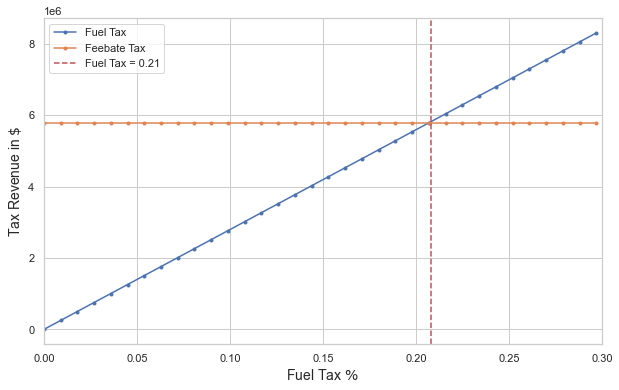

In [38]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(results_df['tax'], results_df['Fuel_tax_taxrevenue_total'], label='Fuel Tax', marker='.')
plt.plot(results_df['tax'], results_df['feebate_taxrevenue'], label='Feebate Tax', marker='.')

# Adding a red dashed line at fuel tax = 0.21
plt.axvline(x=0.208, color='r', linestyle='--', label='Fuel Tax = 0.21')


plt.xlabel('Fuel Tax $\%$', fontsize=14)
plt.ylabel('Tax Revenue in $\$$', fontsize=14)
#plt.title('Tax Revenue Comparison', fontsize=16, weight='bold')
plt.legend()
plt.xlim(0, 0.3)
plt.grid(True)
#plt.show()

#output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
#plt.savefig(output_filepath, format='png')

#Close the plot
#plt.close()

# Provide the path to the saved plot
#output_filepath

**Conclusion: The fuel tax is 21%, as when crossing the 21% mark, we see that Fuel_tax_taxrevenue_total gets higher than feebate_taxrevenue.**

## Counterfactual simulation

In [39]:
cars_est['Intercept'] = 1
cars_est_sim_FuelTax = cars_est.copy()
cars_est_sim_FuelTax = pd.get_dummies(cars_est_sim_FuelTax,columns=['cla_category'],drop_first=True)
cars_est_sim_FuelTax = pd.get_dummies(cars_est_sim_FuelTax,columns=['home_category'],drop_first=True)


# Fuel tax 10%
#tax = grouped_fuelTaxFromFeeBate['percentage_change'].reset_index()

tax = 0.21
cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed'] = (cars_est_sim_FuelTax['Fuel_price_1L']*(1+tax)*cars_est_sim_FuelTax['ann_km']*(cars_est_sim_FuelTax['li']/100))*12
cars_est_sim_FuelTax



,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,s_total_country_cla,s_total_cla,log_s,Intercept,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,Fuel_price_ann_dollar_taxed
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-5.35,1,0,0,0,0,0,4912.35
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.50,1,0,0,0,0,0,4854.21
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.57,1,0,0,0,0,0,4518.47
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.46,1,0,0,0,0,0,2346.45
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.48,1,0,0,0,0,0,2950.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,0.00,0.00,-5.51,1,0,1,0,0,0,3231.67
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,0.00,0.00,-4.75,1,0,0,1,0,1,3469.67
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,0.00,0.00,-3.99,1,0,0,0,1,0,2630.43
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,0.00,0.00,-5.30,1,0,0,0,1,0,2505.17


In [40]:
#merged = pd.merge(cars_est_sim_FuelTax, tax, on='ye', how='left')

# Beregner den skattede brændstofpris
#cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed'] = (merged['Fuel_price_1L'] * (1 + merged['percentage_change'] / 100)) * merged['ann_km'] * (merged['li'] / 100)
#cars_est_sim_FuelTax

In [41]:
print(cars_est_sim_FuelTax.columns)

Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'brand', 'model', 'org',
       'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le',
       'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'country', 'class', 'ann_km', 'Year',
       'priceDollars', 'Fuel_price_1L', 'Fuel_price_ann_dollar', 'pr_dollar',
       'pr_dollar_inc', 'li_qu', 'li_qu_total', 'avg_ann_co2',
       'avg_ann_co2_total', 'qu_total', 'qu_total_ye', 'qu_total_ma',
       'qu_total_ye_ma', 'qu_total_ye_cla', 'qu_total_country_cla',
       'qu_total_cla', 's_total', 's_total_ye', 's_total_ma', 's_total_ye_ma',
       's_total_ye_cla', 's_total_country_cla', 's_total_cla', 'log_s',
       'Intercept', 'cla_category_intermediate', 'cla_category_luxury',
       'cla_category_standard', 'cla_category_subcompact', 'hom

In [42]:
cars_est_sim_FuelTax

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,s_total_country_cla,s_total_cla,log_s,Intercept,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,Fuel_price_ann_dollar_taxed
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-5.35,1,0,0,0,0,0,4912.35
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.50,1,0,0,0,0,0,4854.21
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.57,1,0,0,0,0,0,4518.47
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.46,1,0,0,0,0,0,2346.45
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.48,1,0,0,0,0,0,2950.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,0.00,0.00,-5.51,1,0,1,0,0,0,3231.67
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,0.00,0.00,-4.75,1,0,0,1,0,1,3469.67
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,0.00,0.00,-3.99,1,0,0,0,1,0,2630.43
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,0.00,0.00,-5.30,1,0,0,0,1,0,2505.17


**Market share**

In [43]:
# Kolonner i cars_est_sim_FuelTax, der matcher parametrene i ols_model.params
selected_columns = [
    'cla_category_intermediate',  # [T.intermediate] fjernes for kompatibilitet med DataFrame kolonnenavn
    'cla_category_luxury',  # [T.luxury] fjernes for kompatibilitet med DataFrame kolonnenavn
    'cla_category_standard',  # [T.standard] fjernes for kompatibilitet med DataFrame kolonnenavn
    'cla_category_subcompact',  # [T.subcompact] fjernes for kompatibilitet med DataFrame kolonnenavn
    'home_category_1',  # [T.1] fjernes for kompatibilitet med DataFrame kolonnenavn
    'pr_dollar_inc',
    'li',
    'hp',
    'Fuel_price_ann_dollar_taxed'
]

# Tilføj en kolonne med enere for interceptet, hvis det ikke allerede er en del af cars_est_sim_FuelTax
if 'Intercept' not in cars_est_sim_FuelTax.columns:
    cars_est_sim_FuelTax['Intercept'] = 1

# Nu skal rækkefølgen af kolonner i dataframe matche rækkefølgen af parametre i ols_model.params
# Tilføj 'Intercept' som den første kolonne, hvis den er en del af parametrene
selected_columns = ['Intercept'] + selected_columns

# Vælg de relevante kolonner fra DataFrame
relevant_data = cars_est_sim_FuelTax[selected_columns]

# Beregn prikproduktet
# Vi bruger '.values' for at sikre, at vi bruger NumPy arrays for både DataFrame og parametre
cars_est_sim_results['beta_x_FuelTax'] = np.dot(relevant_data.values, ols_model.params.values)

K_i_FuelTax = cars_est_sim_results['beta_x_FuelTax'].max() 



In [44]:
cars_est_sim_results['exp_beta_x_FuelTax'] = np.exp(cars_est_sim_results['beta_x_FuelTax']-K_i_FuelTax)

In [45]:
ols_model.params

Intercept                      -2.38
cla_category[T.intermediate]    0.07
cla_category[T.luxury]          0.73
cla_category[T.standard]        0.15
cla_category[T.subcompact]     -0.64
home_category[T.1]              1.70
pr_dollar_inc                  -0.21
li                             -0.06
hp                             -0.03
Fuel_price_ann_dollar          -0.00
dtype: float64

### cars_est_sim_FuelTax

In [46]:
# Calculate the sum for every market and year
grouped_sum_ye_ma_feebate = (cars_est_sim_results.groupby(['country', 'ye'])['exp_beta_x_FuelTax'].transform('sum'))
cars_est_sim_results['s_fueltax'] = cars_est_sim_results['exp_beta_x_FuelTax'] / grouped_sum_ye_ma_feebate
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,...,beta_x_baseline,exp_beta_x_baseline,s_base,feebate_taxrevenue,beta_x_FeeBate,exp_beta_x_FeeBate,s_feebate,beta_x_FuelTax,exp_beta_x_FuelTax,s_fueltax
0,83,Belgium,compact,11300,2097.54,1529109.38,0.79,7.77,338.32,65528353,...,-4.92,0.06,0.01,566.31,-4.92,0.06,0.01,-7.37,0.01,0.01
1,84,Belgium,compact,11300,2097.54,3901431.33,0.76,7.77,334.31,65528353,...,-4.91,0.06,0.01,566.31,-4.91,0.06,0.01,-7.33,0.01,0.01
2,85,Belgium,compact,11300,2097.54,3714749.94,0.74,7.77,311.19,65528353,...,-4.90,0.06,0.01,566.31,-4.90,0.06,0.01,-7.14,0.01,0.01
3,86,Belgium,compact,11300,2097.54,4293672.01,0.66,7.77,161.60,65528353,...,-4.80,0.07,0.01,566.31,-4.80,0.07,0.01,-5.97,0.03,0.01
4,87,Belgium,compact,11300,2142.56,4600066.34,0.65,7.93,203.20,65528353,...,-4.83,0.07,0.01,615.34,-4.83,0.07,0.01,-6.30,0.02,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.60,8737629.11,1.50,8.60,222.57,12051088,...,-5.65,0.03,0.00,744.90,-5.67,0.03,0.00,-7.26,0.01,0.00
11545,99,UK,standard,11300,2493.65,20038942.49,1.20,9.23,238.96,21522756,...,-4.05,0.15,0.02,880.78,-4.07,0.14,0.02,-5.78,0.03,0.02
11546,99,UK,subcompact,11300,1890.49,32363298.31,0.49,7.00,181.16,84280296,...,-5.10,0.05,0.01,292.07,-5.11,0.05,0.01,-6.41,0.02,0.01
11547,99,UK,subcompact,11300,1800.47,8357766.07,0.51,6.67,172.53,84280296,...,-4.73,0.07,0.01,170.37,-4.73,0.07,0.01,-5.98,0.03,0.01


In [47]:
pd.set_option('display.float_format', '{:.3f}'.format) # Set decimals 
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,...,beta_x_baseline,exp_beta_x_baseline,s_base,feebate_taxrevenue,beta_x_FeeBate,exp_beta_x_FeeBate,s_feebate,beta_x_FuelTax,exp_beta_x_FuelTax,s_fueltax
0,83,Belgium,compact,11300,2097.544,1529109.377,0.791,7.767,338.316,65528353,...,-4.922,0.061,0.008,566.309,-4.922,0.061,0.008,-7.365,0.007,0.007
1,84,Belgium,compact,11300,2097.544,3901431.332,0.762,7.767,334.312,65528353,...,-4.914,0.061,0.008,566.309,-4.914,0.061,0.008,-7.328,0.007,0.006
2,85,Belgium,compact,11300,2097.544,3714749.940,0.736,7.767,311.189,65528353,...,-4.896,0.063,0.008,566.309,-4.896,0.063,0.008,-7.143,0.008,0.007
3,86,Belgium,compact,11300,2097.544,4293672.009,0.659,7.767,161.601,65528353,...,-4.800,0.069,0.009,566.309,-4.800,0.069,0.009,-5.967,0.027,0.008
4,87,Belgium,compact,11300,2142.555,4600066.338,0.649,7.933,203.203,65528353,...,-4.831,0.067,0.009,615.336,-4.831,0.067,0.009,-6.298,0.019,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.602,8737629.111,1.500,8.600,222.567,12051088,...,-5.651,0.029,0.004,744.895,-5.666,0.029,0.004,-7.258,0.007,0.003
11545,99,UK,standard,11300,2493.646,20038942.487,1.196,9.233,238.958,21522756,...,-4.052,0.146,0.019,880.783,-4.067,0.143,0.019,-5.778,0.033,0.015
11546,99,UK,subcompact,11300,1890.490,32363298.310,0.490,7.000,181.159,84280296,...,-5.105,0.051,0.007,292.071,-5.107,0.051,0.007,-6.413,0.017,0.008
11547,99,UK,subcompact,11300,1800.467,8357766.068,0.513,6.667,172.533,84280296,...,-4.733,0.074,0.010,170.375,-4.734,0.074,0.010,-5.978,0.027,0.012


# Evaluation of the policies

In [48]:
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,...,beta_x_baseline,exp_beta_x_baseline,s_base,feebate_taxrevenue,beta_x_FeeBate,exp_beta_x_FeeBate,s_feebate,beta_x_FuelTax,exp_beta_x_FuelTax,s_fueltax
0,83,Belgium,compact,11300,2097.544,1529109.377,0.791,7.767,338.316,65528353,...,-4.922,0.061,0.008,566.309,-4.922,0.061,0.008,-7.365,0.007,0.007
1,84,Belgium,compact,11300,2097.544,3901431.332,0.762,7.767,334.312,65528353,...,-4.914,0.061,0.008,566.309,-4.914,0.061,0.008,-7.328,0.007,0.006
2,85,Belgium,compact,11300,2097.544,3714749.940,0.736,7.767,311.189,65528353,...,-4.896,0.063,0.008,566.309,-4.896,0.063,0.008,-7.143,0.008,0.007
3,86,Belgium,compact,11300,2097.544,4293672.009,0.659,7.767,161.601,65528353,...,-4.800,0.069,0.009,566.309,-4.800,0.069,0.009,-5.967,0.027,0.008
4,87,Belgium,compact,11300,2142.555,4600066.338,0.649,7.933,203.203,65528353,...,-4.831,0.067,0.009,615.336,-4.831,0.067,0.009,-6.298,0.019,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.602,8737629.111,1.500,8.600,222.567,12051088,...,-5.651,0.029,0.004,744.895,-5.666,0.029,0.004,-7.258,0.007,0.003
11545,99,UK,standard,11300,2493.646,20038942.487,1.196,9.233,238.958,21522756,...,-4.052,0.146,0.019,880.783,-4.067,0.143,0.019,-5.778,0.033,0.015
11546,99,UK,subcompact,11300,1890.490,32363298.310,0.490,7.000,181.159,84280296,...,-5.105,0.051,0.007,292.071,-5.107,0.051,0.007,-6.413,0.017,0.008
11547,99,UK,subcompact,11300,1800.467,8357766.068,0.513,6.667,172.533,84280296,...,-4.733,0.074,0.010,170.375,-4.734,0.074,0.010,-5.978,0.027,0.012


## Calculate all sales by the new market share

In [49]:
pd.set_option('display.float_format', '{:.0f}'.format)
cars_est_sim_results['qu_observed'] = cars_est_sim_results['s_total_ye_ma'] * cars_est_sim_results['qu_total_ye_ma']
cars_est_sim_results['qu_baseline'] = cars_est_sim_results['s_base'] * cars_est_sim_results['qu_total_ye_ma']
cars_est_sim_results['qu_FeeBate'] = cars_est_sim_results['s_feebate'] * cars_est_sim_results['qu_total_ye_ma']
cars_est_sim_results['qu_FuelTax'] = cars_est_sim_results['s_fueltax'] * cars_est_sim_results['qu_total_ye_ma']
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,...,beta_x_FeeBate,exp_beta_x_FeeBate,s_feebate,beta_x_FuelTax,exp_beta_x_FuelTax,s_fueltax,qu_observed,qu_baseline,qu_FeeBate,qu_FuelTax
0,83,Belgium,compact,11300,2098,1529109,1,8,338,65528353,...,-5,0,0,-7,0,0,729,2471,2471,2189
1,84,Belgium,compact,11300,2098,3901431,1,8,334,65528353,...,-5,0,0,-7,0,0,1860,2591,2591,2138
2,85,Belgium,compact,11300,2098,3714750,1,8,311,65528353,...,-5,0,0,-7,0,0,1771,2785,2784,2306
3,86,Belgium,compact,11300,2098,4293672,1,8,162,65528353,...,-5,0,0,-6,0,0,2047,3147,3147,2792
4,87,Belgium,compact,11300,2143,4600066,1,8,203,65528353,...,-5,0,0,-6,0,0,2147,3460,3459,2868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2323,8737629,2,9,223,12051088,...,-6,0,0,-7,0,0,3762,7271,7206,6370
11545,99,UK,standard,11300,2494,20038942,1,9,239,21522756,...,-4,0,0,-6,0,0,8036,35972,35679,27996
11546,99,UK,subcompact,11300,1890,32363298,0,7,181,84280296,...,-5,0,0,-6,0,0,17119,12558,12611,14835
11547,99,UK,subcompact,11300,1800,8357766,1,7,173,84280296,...,-5,0,0,-6,0,0,4642,18219,18310,22906


In [50]:
pd.set_option('display.float_format', '{:.0f}'.format)

# Relevant columns 
cars_co2 = cars_est_sim_results[['ye','country','class','ann_km','li','Fuel_price_ann_dollar','qu_observed','qu_total_ye_ma','qu_total_cla','qu_total','qu_baseline','s_base','qu_FeeBate','s_feebate','qu_FuelTax','s_fueltax']]
cars_co2.sum()

ye                                                                  986642
country                  BelgiumBelgiumBelgiumBelgiumBelgiumBelgiumBelg...
class                    compactcompactcompactcompactcompactcompactcomp...
ann_km                                                           130503700
li                                                                   94470
Fuel_price_ann_dollar                                              2330590
qu_observed                                                      228823056
qu_total_ye_ma                                                 17453279988
qu_total_cla                                                  622595308131
qu_total                                                     2642677473744
qu_baseline                                                      228823056
s_base                                                                 150
qu_FeeBate                                                       228823056
s_feebate                

## Dataframe for summaries


In [51]:
cars_co2

,ye,country,class,ann_km,li,Fuel_price_ann_dollar,qu_observed,qu_total_ye_ma,qu_total_cla,qu_total,qu_baseline,s_base,qu_FeeBate,s_feebate,qu_FuelTax,s_fueltax
0,83,Belgium,compact,11300,8,338,729,305920,65528353,228823056,2471,0,2471,0,2189,0
1,84,Belgium,compact,11300,8,334,1860,333772,65528353,228823056,2591,0,2591,0,2138,0
2,85,Belgium,compact,11300,8,311,1771,340409,65528353,228823056,2785,0,2784,0,2306,0
3,86,Belgium,compact,11300,8,162,2047,353558,65528353,228823056,3147,0,3147,0,2792,0
4,87,Belgium,compact,11300,8,203,2147,379407,65528353,228823056,3460,0,3459,0,2868,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,9,223,3762,1859851,12051088,228823056,7271,0,7206,0,6370,0
11545,99,UK,standard,11300,9,239,8036,1859851,21522756,228823056,35972,0,35679,0,27996,0
11546,99,UK,subcompact,11300,7,181,17119,1859851,84280296,228823056,12558,0,12611,0,14835,0
11547,99,UK,subcompact,11300,7,173,4642,1859851,84280296,228823056,18219,0,18310,0,22906,0


In [52]:
cars_co2 = cars_co2.copy()

emission_factor = 2.39

cars_co2['co2_qu_total_per_cartype_sum_observed'] = (cars_co2['li']/100)*cars_co2['ann_km']*cars_co2['qu_observed']*emission_factor
cars_co2['co2_qu_total_per_cartype_sum_FeeBate'] = (cars_co2['li']/100)*cars_co2['ann_km']*cars_co2['qu_FeeBate'] *emission_factor
#cars_co2['co2_diff_Per_Cartype'] = cars_co2['co2_qu_total_per_cartype_sum_observed']-cars_co2['co2_qu_total_per_cartype_sum_FeeBate']


cars_co2['co2_qu_total_per_cartype_sum_FuelTax'] = (cars_co2['li']/100)*cars_co2['ann_km']*cars_co2['qu_FuelTax'] *emission_factor

cars_co2['co2_qu_total_per_cartype_sum_Baseline'] = (cars_co2['li']/100)*cars_co2['ann_km']*cars_co2['qu_baseline'] *emission_factor
cars_co2

,ye,country,class,ann_km,li,Fuel_price_ann_dollar,qu_observed,qu_total_ye_ma,qu_total_cla,qu_total,qu_baseline,s_base,qu_FeeBate,s_feebate,qu_FuelTax,s_fueltax,co2_qu_total_per_cartype_sum_observed,co2_qu_total_per_cartype_sum_FeeBate,co2_qu_total_per_cartype_sum_FuelTax,co2_qu_total_per_cartype_sum_Baseline
0,83,Belgium,compact,11300,8,338,729,305920,65528353,228823056,2471,0,2471,0,2189,0,1529109,5183606,4591450,5183947
1,84,Belgium,compact,11300,8,334,1860,333772,65528353,228823056,2591,0,2591,0,2138,0,3901431,5433791,4485257,5434216
2,85,Belgium,compact,11300,8,311,1771,340409,65528353,228823056,2785,0,2784,0,2306,0,3714750,5840605,4836554,5841044
3,86,Belgium,compact,11300,8,162,2047,353558,65528353,228823056,3147,0,3147,0,2792,0,4293672,6601224,5857319,6601695
4,87,Belgium,compact,11300,8,203,2147,379407,65528353,228823056,3460,0,3459,0,2868,0,4600066,7411748,6145494,7412436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,9,223,3762,1859851,12051088,228823056,7271,0,7206,0,6370,0,8737629,16735602,14794868,16888190
11545,99,UK,standard,11300,9,239,8036,1859851,21522756,228823056,35972,0,35679,0,27996,0,20038942,88969678,69812221,89702055
11546,99,UK,subcompact,11300,7,181,17119,1859851,84280296,228823056,12558,0,12611,0,14835,0,32363298,23840358,28045014,23739838
11547,99,UK,subcompact,11300,7,173,4642,1859851,84280296,228823056,18219,0,18310,0,22906,0,8357766,32965871,41240942,32801868


# PR BIL

**Market Share After Taxations**

In [53]:
pd.set_option('display.float_format', '{:.3f}'.format)

cars_s_class = cars_est_sim_results.groupby(['class']).sum()
cars_s_class= cars_s_class[['s_base','s_feebate','s_fueltax']]

class_order = ['subcompact', 'compact', 'standard', 'intermediate', 'luxury']
cars_s_class = cars_s_class.reindex(class_order)


# Dividerer alle værdier med 150
cars_s_class = cars_s_class / 150


#cars_s_class.loc['Total per class', :] = cars_s_class.sum(axis=0)

cars_s_class

,s_base,s_feebate,s_fueltax
class,,,
subcompact,0.355,0.357,0.415
compact,0.298,0.298,0.295
standard,0.100,0.098,0.077
intermediate,0.205,0.204,0.184
luxury,0.042,0.042,0.029


In [54]:
cars_s_class = cars_est_sim_results.groupby(['class']).sum()
cars_s_class= cars_s_class[['s_base','s_feebate','s_fueltax']]

class_order = ['subcompact', 'compact', 'standard', 'intermediate', 'luxury']
cars_s_class = cars_s_class.reindex(class_order)


# Dividerer alle værdier med 150
cars_s_class = cars_s_class / 150


#cars_s_class.loc['Total per class', :] = cars_s_class.sum(axis=0)

cars_s_class

,s_base,s_feebate,s_fueltax
class,,,
subcompact,0.355,0.357,0.415
compact,0.298,0.298,0.295
standard,0.100,0.098,0.077
intermediate,0.205,0.204,0.184
luxury,0.042,0.042,0.029


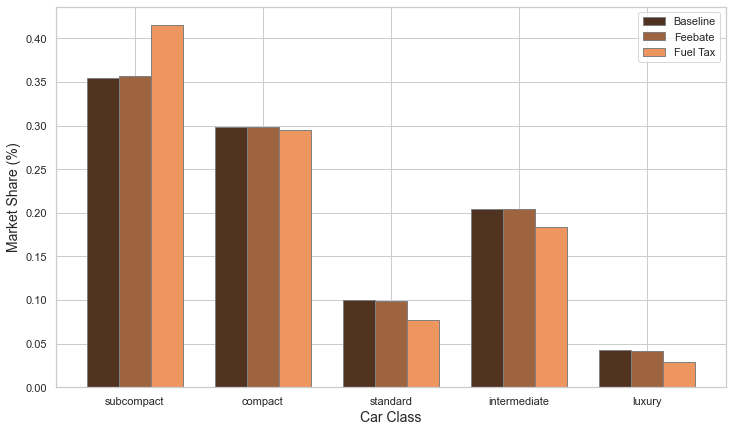

In [55]:
cars_s_class = cars_est_sim_results.groupby(['class']).sum()

cars_s_class = cars_s_class[['s_base','s_feebate','s_fueltax']]

cars_s_class = cars_s_class / 150


cars_s_class = cars_s_class.reset_index()

# Reindexerer
class_order = ['subcompact', 'compact', 'standard', 'intermediate', 'luxury']
cars_s_class = cars_s_class.set_index('class').reindex(class_order).reset_index()


# color
palette = sns.color_palette("copper", n_colors=3)

plt.figure(figsize=(12, 7))
barWidth = 0.25
r1 = np.arange(len(cars_s_class))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


plt.bar(r1, cars_s_class['s_base'], color=palette[0], width=barWidth, edgecolor='grey', label='Baseline')
plt.bar(r2, cars_s_class['s_feebate'], color=palette[1], width=barWidth, edgecolor='grey', label='Feebate')
plt.bar(r3, cars_s_class['s_fueltax'], color=palette[2], width=barWidth, edgecolor='grey', label='Fuel Tax')


plt.xlabel('Car Class', fontsize=14)
plt.ylabel('Market Share (%)',fontsize=14)
plt.xticks([r + barWidth for r in range(len(cars_s_class))], cars_s_class['class'])

#plt.title('Market Share for Different Policies',fontsize=16,weight='bold')
plt.legend()
#plt.show()


#output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
#plt.savefig(output_filepath, format='png')

#Close the plot
#plt.close()

# Provide the path to the saved plot
#output_filepath


**CO$_2$ Emissions**

In [56]:
cars_co2_class = cars_co2.groupby(['class']).sum()
cars_co2_class= cars_co2_class[['co2_qu_total_per_cartype_sum_Baseline','co2_qu_total_per_cartype_sum_FeeBate','co2_qu_total_per_cartype_sum_FuelTax']]

class_order = ['subcompact', 'compact', 'standard', 'intermediate', 'luxury']
cars_co2_class = cars_co2_class.reindex(class_order)


cars_co2_class.loc['Total per class', :] = cars_co2_class.sum(axis=0)

cars_co2_class

,co2_qu_total_per_cartype_sum_Baseline,co2_qu_total_per_cartype_sum_FeeBate,co2_qu_total_per_cartype_sum_FuelTax
class,,,
subcompact,140331600742.392,141066855631.403,162616527821.302
compact,140787950887.880,140738082759.673,138320195221.740
standard,56587997286.834,55840510243.881,43293504749.757
intermediate,104395945686.435,104100016831.487,92558591481.282
luxury,28219093265.597,27947090438.804,19093407254.183
Total per class,470322587869.138,469692555905.248,455882226528.265


In [57]:
#cars_co2_class = cars_co2.groupby(['class']).sum()
#cars_co2_class= cars_co2_class[['co2_qu_total_per_cartype_sum_Baseline','co2_qu_total_per_cartype_sum_FeeBate','co2_qu_total_per_cartype_sum_FuelTax']]

#cars_co2_class = cars_co2_class.reset_index()

#cars_co2_class 

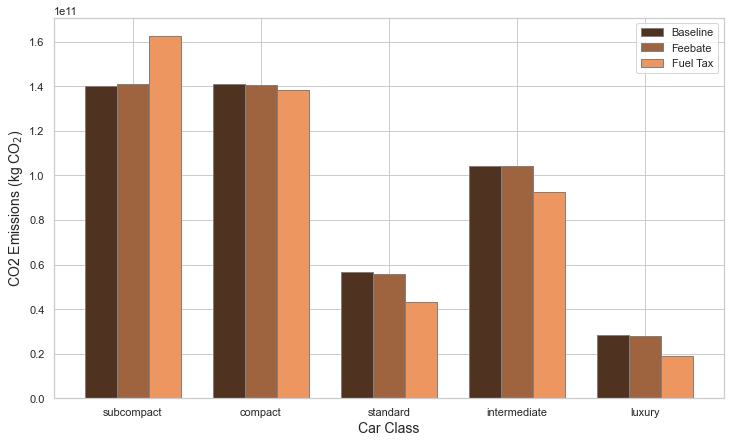

In [58]:
cars_co2_class = cars_co2.groupby(['class']).sum()
cars_co2_class= cars_co2_class[['co2_qu_total_per_cartype_sum_Baseline','co2_qu_total_per_cartype_sum_FeeBate','co2_qu_total_per_cartype_sum_FuelTax']]



class_order = ['subcompact', 'compact', 'standard', 'intermediate', 'luxury']
cars_co2_class = cars_co2_class.reindex(class_order)
cars_co2_class = cars_co2_class.reset_index()

#import seaborn as sns



# color choosen 
palette = sns.color_palette("copper", n_colors=3)

plt.figure(figsize=(12, 7))
barWidth = 0.25
r1 = np.arange(len(cars_co2_class))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


# bars and color pallet
plt.bar(r1, cars_co2_class['co2_qu_total_per_cartype_sum_Baseline'], color=palette[0], width=barWidth, edgecolor='grey', label='Baseline')
plt.bar(r2, cars_co2_class['co2_qu_total_per_cartype_sum_FeeBate'], color=palette[1], width=barWidth, edgecolor='grey', label='Feebate')
plt.bar(r3, cars_co2_class['co2_qu_total_per_cartype_sum_FuelTax'], color=palette[2], width=barWidth, edgecolor='grey', label='Fuel Tax')


plt.xlabel('Car Class', fontsize=14)
plt.ylabel('CO2 Emissions (kg CO$_2$)',fontsize=14)
plt.xticks([r + barWidth for r in range(len(cars_co2_class))], cars_co2_class['class'])

#plt.title('CO2 Emissions by Car Class for Different Policies',fontsize=16,weight='bold')
plt.legend()
plt.show()


**Color packages**

In [59]:
cars_co2_class = cars_co2.groupby(['class']).sum()
cars_co2_class= cars_co2_class[['co2_qu_total_per_cartype_sum_Baseline','co2_qu_total_per_cartype_sum_FeeBate','co2_qu_total_per_cartype_sum_FuelTax']]

class_order = ['subcompact', 'compact', 'standard', 'intermediate', 'luxury']
cars_co2_class = cars_co2_class.reindex(class_order)

# Tilføjer en række med samlede værdier per klasse
cars_co2_class.loc['Total per class', :] = cars_co2_class.sum(axis=0)

# Beregner den procentvise forskel fra Baseline for FeeBate og FuelTax
cars_co2_class['Feebate vs Baseline (%)'] = ((cars_co2_class['co2_qu_total_per_cartype_sum_FeeBate'] - cars_co2_class['co2_qu_total_per_cartype_sum_Baseline']) / cars_co2_class['co2_qu_total_per_cartype_sum_Baseline']) * 100
cars_co2_class['FuelTax vs Baseline (%)'] = ((cars_co2_class['co2_qu_total_per_cartype_sum_FuelTax'] - cars_co2_class['co2_qu_total_per_cartype_sum_Baseline']) / cars_co2_class['co2_qu_total_per_cartype_sum_Baseline']) * 100
cars_co2_class


,co2_qu_total_per_cartype_sum_Baseline,co2_qu_total_per_cartype_sum_FeeBate,co2_qu_total_per_cartype_sum_FuelTax,Feebate vs Baseline (%),FuelTax vs Baseline (%)
class,,,,,
subcompact,140331600742.392,141066855631.403,162616527821.302,0.524,15.880
compact,140787950887.880,140738082759.673,138320195221.740,-0.035,-1.753
standard,56587997286.834,55840510243.881,43293504749.757,-1.321,-23.493
intermediate,104395945686.435,104100016831.487,92558591481.282,-0.283,-11.339
luxury,28219093265.597,27947090438.804,19093407254.183,-0.964,-32.339
Total per class,470322587869.138,469692555905.248,455882226528.265,-0.134,-3.070


In [60]:
latex_table = cars_co2_class.to_latex(index=True, float_format="%.2f")
latex_table


/var/folders/fq/jrmcw87s5bvdvtl2jq535p1m0000gn/T/ipykernel_9128/624929730.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = cars_co2_class.to_latex(index=True, float_format="%.2f")


'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  co2\\_qu\\_total\\_per\\_cartype\\_sum\\_Baseline &  co2\\_qu\\_total\\_per\\_cartype\\_sum\\_FeeBate &  co2\\_qu\\_total\\_per\\_cartype\\_sum\\_FuelTax &  Feebate vs Baseline (\\%) &  FuelTax vs Baseline (\\%) \\\\\nclass           &                                        &                                       &                                       &                          &                          \\\\\n\\midrule\nsubcompact      &                        140331600742.39 &                       141066855631.40 &                       162616527821.30 &                     0.52 &                    15.88 \\\\\ncompact         &                        140787950887.88 &                       140738082759.67 &                       138320195221.74 &                    -0.04 &                    -1.75 \\\\\nstandard        &                         56587997286.83 &                        55840510243.88 &                        43293504749.76

### Difference på Baseline og Fuel Tax udledning, for hver Fueltax pr. 30 år

In [61]:
# co2_qu_total_per_cartype_sum_Baseline per class
#- co2_qu_total_per_cartype_sum_FuelTax per class
#/ co2_qu_total_per_cartype_sum_FuelTax
# = Difference in emission for Baseline and Fueltax pr. Fueltax
(470322587869.138-455882226528.260)/455882226528.260

0.03167564011180602

### Feebate CO$_2$ Emissions

In [62]:
print('Fuel Tax udledning difference for 30 år:',(470322587869.138-468024888045.671))
print('Fuel Tax udledning difference pr år:',(470322587869.138-468024888045.671)/30)

Fuel Tax udledning difference for 30 år: 2297699823.46698
Fuel Tax udledning difference pr år: 76589994.115566


### Fuel tax CO$_2$ Emissions

In [63]:
print('Fuel Tax udledning difference for 30 år:',(470322587869.138-455882226528.260))
print('Fuel Tax udledning difference pr år:',(470322587869.138-455882226528.260)/30)

Fuel Tax udledning difference for 30 år: 14440361340.87799
Fuel Tax udledning difference pr år: 481345378.02926636


In [64]:
468024888045.671-455882226528.260

12142661517.41101

In [65]:
76589994-481345378

-404755384

In [66]:
print('Så meget mindre ville en fuel tax udlede ift feebate',((470322587869.138-468024888045.671)/30)-((470322587869.138-455882226528.260)/30))

Så meget mindre ville en fuel tax udlede ift feebate -404755383.91370034


# Make a CO$_2$ graph

In [67]:
# CO2 udledning får hvert år med Baseline og Feebate 
cars_co2_class = cars_co2.groupby(['ye']).sum()
cars_co2_class= cars_co2_class[['co2_qu_total_per_cartype_sum_Baseline','co2_qu_total_per_cartype_sum_FeeBate','co2_qu_total_per_cartype_sum_FuelTax']]
cars_co2_class.reset_index()

,ye,co2_qu_total_per_cartype_sum_Baseline,co2_qu_total_per_cartype_sum_FeeBate,co2_qu_total_per_cartype_sum_FuelTax
0,70,12635229346.976,12575084475.230,12460682097.553
1,71,14027532266.758,13953928852.605,13767468325.818
2,72,15421156306.522,15332639383.071,15150373213.548
3,73,14598364709.931,14520865197.981,14304982268.725
4,74,12768861610.892,12716807444.273,12337590082.767
5,75,12140934068.023,12111207894.100,11815860963.361
6,76,13726909056.048,13702645274.398,13310915530.062
7,77,14574659967.331,14550746195.890,14198886868.170
8,78,14543234711.887,14523099063.259,14123552141.188
9,79,15305902594.728,15289018866.387,14925344501.695


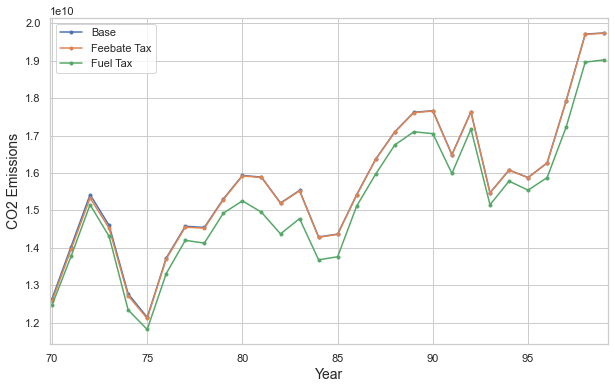

In [68]:
cars_co2_class_reset = cars_co2_class.reset_index()

# Plotting
plt.figure(figsize=(10, 6))

for column, label in zip(['co2_qu_total_per_cartype_sum_Baseline', 'co2_qu_total_per_cartype_sum_FeeBate', 'co2_qu_total_per_cartype_sum_FuelTax'], 
                         ['Base','Feebate Tax', 'Fuel Tax']):
    plt.plot(cars_co2_class_reset['ye'], cars_co2_class_reset[column], label=label, marker='.')

plt.xlabel('Year', fontsize=14)
plt.ylabel('CO2 Emissions', fontsize=14)
#plt.title('CO2 Emissions over Years for Different Policies', fontsize=16, weight='bold')
plt.legend()
plt.xlim(69.9, 99.2)
plt.show()


#output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
#plt.savefig(output_filepath, format='png')

#Close the plot
#plt.close()

# Provide the path to the saved plot
#output_filepath

(69.9, 99.2)

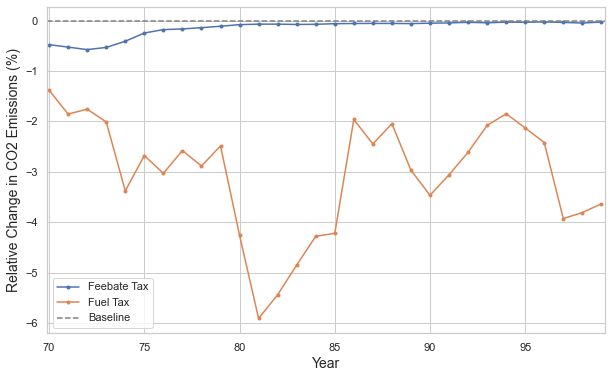

In [69]:
baseline = cars_co2_class_reset['co2_qu_total_per_cartype_sum_Baseline']

plt.figure(figsize=(10, 6))

# Plotte hver kolonne relativt til baseline med simplificerede labels
for column, label in zip(['co2_qu_total_per_cartype_sum_FeeBate', 'co2_qu_total_per_cartype_sum_FuelTax'], 
                         ['Feebate Tax', 'Fuel Tax']):
    relative_change = (cars_co2_class_reset[column] - baseline) / baseline * 100  # Procentvis ændring
    plt.plot(cars_co2_class_reset['ye'], relative_change, label=label, marker='.')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Relative Change in CO2 Emissions (%)', fontsize=14)
#plt.title('Relative Change in CO2 Emissions over Years Compared to Baseline', fontsize=16, weight='bold')
plt.axhline(0, color='grey', linestyle='--',label='Baseline')  # Tilføjer en horisontal linje for baseline
plt.legend()
plt.xlim(69.9, 99.2)
#plt.show()



#output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
#plt.savefig(output_filepath, format='png')

#Close the plot
#plt.close()

# Provide the path to the saved plot
#output_filepath


Involvere:
- Landenes exchange rate ift. dollars:
    - Frankrig: https://www.poundsterlinglive.com/bank-of-england-spot/historical-spot-exchange-rates/usd/USD-to-FRF-1990
    - 

# Fuel prices by class

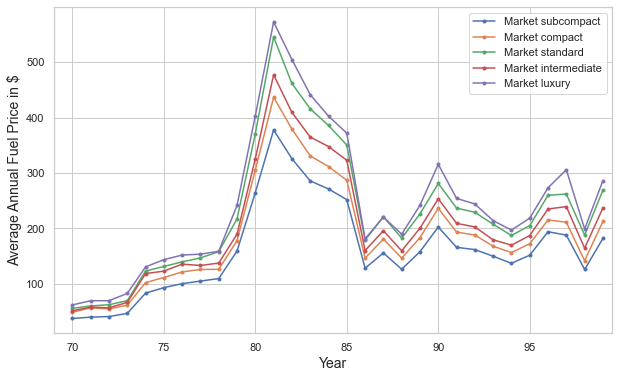

In [70]:
class_order = ['subcompact','compact', 'standard', 'intermediate', 'luxury']
# Plots
cars_grouped = cars.groupby(['ye', 'class']).agg({'Fuel_price_ann_dollar': 'mean'}).reset_index()

# Pivot the data for plotting
cars_pivoted = cars_grouped.pivot(index='ye', columns='class', values='Fuel_price_ann_dollar')
cars_pivoted = cars_pivoted[class_order]

# Plotting the data
plt.figure(figsize=(10, 6))

# Plotting each market as a separate line
for column in cars_pivoted.columns:
    plt.plot(cars_pivoted.index, cars_pivoted[column], marker='.', label=f'Market {column}')

#plt.title('Average Annual Fuel Price in Dollars by Class Over Time', fontsize=16,weight='bold')
plt.xlabel('Year', fontsize=14)
plt.xlim(69, 99.5)
plt.ylabel('Average Annual Fuel Price in $', fontsize=14)
plt.legend()
plt.grid(True)
#plt.show()

#output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
#plt.savefig(output_filepath, format='png')

#Close the plot
#plt.close()

# Provide the path to the saved plot
#output_filepath

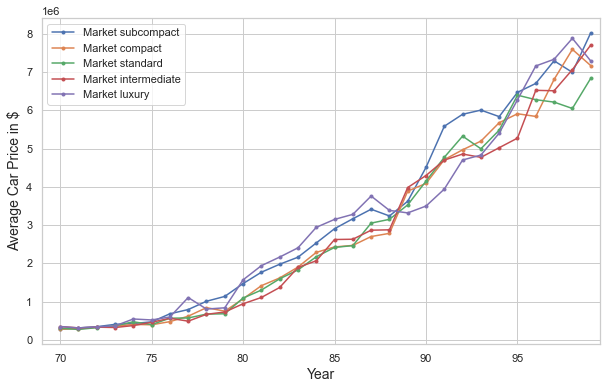

In [71]:
# Plots
cars_grouped = cars.groupby(['ye', 'class']).agg({'pr_dollar': 'mean'}).reset_index()

# Pivot the data for plotting
cars_pivoted = cars_grouped.pivot(index='ye', columns='class', values='pr_dollar')
cars_pivoted = cars_pivoted[class_order]

# Plotting the data
plt.figure(figsize=(10, 6))

# Plotting each market as a separate line
for column in cars_pivoted.columns:
    plt.plot(cars_pivoted.index, cars_pivoted[column], marker='.', label=f'Market {column}')

#plt.title('Average Car Price in Dollars by Class Over Time', fontsize=16,weight='bold')
plt.xlabel('Year', fontsize=14)
plt.xlim(69, 99.5) 
plt.ylabel('Average Car Price in $', fontsize=14)
plt.legend()
plt.grid(True)
#plt.show()


#output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
#plt.savefig(output_filepath, format='png')

#Close the plot
#plt.close()

# Provide the path to the saved plot
#output_filepath

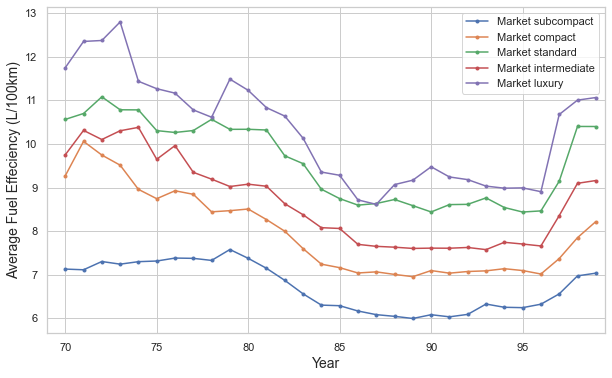

In [72]:
# Plots
cars_grouped = cars.groupby(['ye', 'class']).agg({'li': 'mean'}).reset_index()

# Pivot the data for plotting
cars_pivoted = cars_grouped.pivot(index='ye', columns='class', values='li')
cars_pivoted = cars_pivoted[class_order]

# Plotting the data
plt.figure(figsize=(10, 6))



# Plotting each market as a separate line
for column in cars_pivoted.columns:
    plt.plot(cars_pivoted.index, cars_pivoted[column], marker='.', label=f'Market {column}')

#plt.title('Average Development of Fuel Effeciency by Class Over Time', fontsize=16,weight='bold')
plt.xlabel('Year', fontsize=14)
plt.xlim(69, 99.5) 
plt.ylabel('Average Fuel Effeciency (L/100km)', fontsize=14)
plt.legend()
plt.grid(True)
#plt.show()


#output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
#plt.savefig(output_filepath, format='png')

#Close the plot
#plt.close()

# Provide the path to the saved plot
#output_filepath

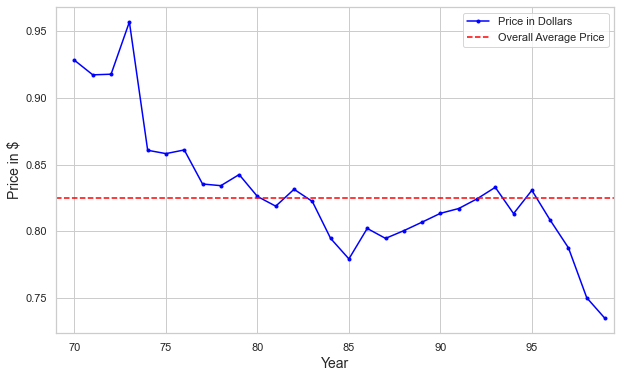

In [73]:

# Group the data by 'ye' and calculate the mean of 'priceDollars'
grouped_data = cars.groupby('ye')['princ'].mean().reset_index()

# Calculate the overall mean of 'priceDollars'
overall_mean = cars['princ'].mean()

# Plot the data
plt.figure(figsize=(10, 6))

# Plot the average price in dollars over years
plt.plot(grouped_data['ye'], grouped_data['princ'], marker='.', color='blue', label='Price in Dollars')

# Add the overall mean line to the plot
plt.axhline(y=overall_mean, color='red', linestyle='--', label='Overall Average Price')

#plt.title('Average Price Development of one Oil Barrel Over Years', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.xlim(69, 99.5) 
plt.ylabel('Price in $', fontsize=14)
plt.legend()
plt.grid(True)
#plt.show()

#output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
#plt.savefig(output_filepath, format='png')

#Close the plot
#plt.close()

# Provide the path to the saved plot
#output_filepath

Få styr på: Baseline, graferne, emission factor (hvorfra), (market_annual_driving), hvorfor dividere med 0.5? (15), hvorfor prikproduktet (21), hvorfor definere vektorer (16), Mere præcis på Baseline (20), Referere præcis formel (24), (hvor kommer konstanterne fra (27)), prikprodukt (32), -K_i_FeeBate (33), hvorfor 20?, lave om på titler osv. når jeg omskriver, hvorfor tax= 0.1 (36), formler for Fuel_price_ann_dollar_taxed osv. (36), tax_rates = np.arange(0.0, 0.3, 0.009) (37)? for loop også, læser paper om feebate så jeg kan kommentere på det, 